# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercício é treinar e avaliar um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X.

As métricas a serem reportadas são F1 e Equal Error Rate (ERR) e seu respectivo threshold.

Note que uma das dificuldades deste exercicio será processar as imagens, que tem 1100 x 1100 pixels.

Dica: Utilize o [pyeer](https://pypi.org/project/pyeer/) para plotar o EER.

## Inicialização do Neptune

In [1]:
import os
import neptune.new as neptune

class FakeNeptuneLogger:
    def log(self, *args):
        pass

class FakeNeptuneClient:
    def __setitem__(self, key, value):
        pass
    
    def __getitem__(self, value):
        return FakeNeptuneLogger()

def get_neptune_client():
    api_token = os.getenv('NEPTUNE_API_TOKEN')
    
    if api_token is not None:
        return neptune.init(
            project='pfracarolli/pfracarolli-e7',
            api_token=api_token
        )
    
    return FakeNeptuneClient()

run = get_neptune_client()

## Importação das bibliotecas

In [2]:
from collections import OrderedDict
import h5py
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import transforms

import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

## Dataset e dataloader

### Carregamento, criação dataset e do dataloader

In [3]:
if not os.path.exists('./data'):
    !mkdir ./data
    !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* ./data

Aqui criamos um dataset sem aumento de dados

In [4]:
size_final = (224, 224)

transform_train = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=size_final),
    torchvision.transforms.Lambda(lambda x: x.tile(3,1,1)),
    # normalization params for resnet
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

transform_valid = transform_train

In [5]:
class Hdf5Dataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, n_dataset_splits=2):
        self.h5file = h5py.File(path, 'r')    
        self.transform = transform
        
        l = len(self.h5file['label'])
        
        self.split_size = l // n_dataset_splits
        self.__load_split(0)
        
    def __load_split(self, split):
        self.split = split
        lo, hi = self.split, self.split + self.split_size
        self.images = self.h5file['data'][lo:hi]
        self.labels = self.h5file['label'][lo:hi]
        
    def __get_image_and_label(self, idx):
        split = idx // self.split_size
        
        if split != self.split:
            self.__load_split(split)
            
        index = idx - self.split * self.split_size
        
        return (
            self.images[index].astype(np.uint8), 
            self.labels[index].astype(np.int64)
        )

    def __len__(self):
        return len(self.h5file['label'])

    def __getitem__(self, idx):
        img, label = self.__get_image_and_label(idx)
        img = self.transform(img)
      
        return img, label
    
class MemoryHdf5Dataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, ds_size=3000):
        with h5py.File(path, 'r') as h5file:
            self.images = h5file['data'][:ds_size]
            self.labels = h5file['label'][:ds_size]
            
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx].astype(np.int64)
        img = self.images[idx].astype(np.uint8)
        img = self.transform(img)
      
        return img, label

In [6]:
train_dataset = MemoryHdf5Dataset('./data/train.hdf5', transform=transform_train)
val_dataset = MemoryHdf5Dataset('./data/valid.hdf5', transform=transform_valid)
test_dataset = MemoryHdf5Dataset('./data/test.hdf5', transform=transform_valid)

In [7]:
batch_size = 30

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Number of training batches:', len(train_dataloader))
print('Number of validation batches:', len(val_dataloader))
print('Number of test batches:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print('Size of a minibatch:', x_train.size())
print('Min and max pixel values:', torch.min(x_train), torch.max(x_train))
print('Image datatype:', type(x_train))
print('Label dataype:', type(y_train))
print(y_train[:10])

Number of training batches: 100
Number of validation batches: 34
Number of test batches: 34
Size of a minibatch: torch.Size([30, 3, 224, 224])
Min and max pixel values: tensor(-2.1179) tensor(2.6394)
Image datatype: <class 'torch.Tensor'>
Label dataype: <class 'torch.Tensor'>
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])


## Criação do modelo

In [8]:
from torchvision.models import resnet50
from torch.nn import Module, Linear, Sequential

class Model(Module):
    def __init__(self, pretrained=False):
        super().__init__()
        resnet = resnet50(pretrained=pretrained)
        
        if pretrained:
            for param in resnet.parameters():
                param.requires_grad = False
                
            # only train the fully-connected layer of the
            # resnet when pretrained == TRue
            for param in resnet.fc.parameters():
                param.requires_grad = True
        
        backbone = Sequential(
            resnet,
            Linear(
                in_features=resnet.fc.out_features,
                out_features=1
            )
        )
            
        
        self.__backbone = backbone
        
    def forward(self, x):
        return self.__backbone.forward(x)        
    
    def __str__(self):
        return str(self.__backbone)
    
    __repr__ = __str__
        
# making a prediction
model = Model()

x, _ = next(iter(train_dataloader))
y_hat = model.forward(x).sigmoid()
print(y_hat.size())
print(y_hat[:10])
    

torch.Size([30, 1])
tensor([[0.4061],
        [0.4276],
        [0.4331],
        [0.4366],
        [0.4501],
        [0.5482],
        [0.5208],
        [0.4121],
        [0.4232],
        [0.4808]], grad_fn=<SliceBackward>)


In [9]:
from pytorch_lightning import LightningModule
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD

train_losses = []
val_losses = []

class LightningModel(LightningModule):
    def __init__(
        self, 
        lr=0.01, 
        decision_threshold=0.5, 
        loss_fn=BCEWithLogitsLoss(), 
        optimizer=SGD, 
        neptune_logger=run,
        momentum=0.2,
        pretrained=False
    ):
        super().__init__()
        
        self.model = Model(pretrained=pretrained)
        self.optimizer_builder = optimizer
        self.loss_fn = loss_fn
        self.neptune_logger = neptune_logger
        self.learning_rate = lr
        self.momentum = momentum
        self.decision_threshold = decision_threshold
        self.neptune_logger_name = 'pretrained' if pretrained else 'not_pretrained'
        
        self.mean_train_losses = []
        self.mean_train_accuracies = []
        
        self.mean_val_losses = []
        self.mean_val_accuracies = []
        
        self.neptune_logger['hparams'] = {
            'loss_fn': str(self.loss_fn),
            'lr': self.learning_rate,
            'decision_threshold': self.decision_threshold,
            'pretrained': pretrained
        }
        
    def __log_metrics(self, container_name, loss, accuracy):
        prefix = f'{self.neptune_logger_name}/{container_name}'
        
        self.neptune_logger[f'{prefix}/loss'].log(loss)
        self.neptune_logger[f'{prefix}/accuracy'].log(accuracy)
        
    def __get_metrics(self, batch):
        x, y = batch
        y_pred = self.model.forward(x)
        
        y_pred = y_pred.flatten().float()
        y = y.flatten().float()
        
        loss = self.loss_fn(y_pred, y)
        
        decision = (y_pred.sigmoid() >= self.decision_threshold)
        accuracy = decision[decision == y]
        accuracy = len(accuracy) / len(y)
        
        trues = len(y[y == 1])
        
        tp = len(y_pred[(y == 1) & decision])
        fp = len(y_pred[(y != 1) & decision])
        
        true_preds = (tp + fp)
        
        precision = (tp / true_preds) if true_preds > 0 else 0
        recall = (tp / trues) if trues > 0 else 0
        
        return loss, accuracy, precision, recall
    
    def __process_mean_metrics(self, outputs, step_name):
        mean_loss = 0
        mean_accuracy = 0
        mean_precision = 0
        mean_recall = 0
        
        l = len(outputs)
        
        for output in outputs:
            mean_loss += output['loss']
            mean_accuracy += output['accuracy']
            mean_precision += output['precision']
            mean_recall += output['recall']
              
        mean_loss /= l 
        mean_accuracy /= l
        mean_precision /= l
        mean_recall /= l
        
        self.__log_metrics(step_name, mean_loss, mean_accuracy)
        
        return mean_loss, mean_accuracy, mean_precision, mean_recall
        
    def training_step(self, batch, batch_idx):
        loss, accuracy, precision, recall = self.__get_metrics(batch)    
        return {'loss': loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall}
    
    validation_step = training_step
    test_step = training_step
    
    def training_epoch_end(self, outputs):
        loss, accuracy, _, _ = self.__process_mean_metrics(outputs, 'train')
        
        self.mean_train_losses.append(loss.cpu())
        self.mean_train_accuracies.append(accuracy)
        
    def validation_epoch_end(self, outputs):
        loss, accuracy, _, _ = self.__process_mean_metrics(outputs, 'validation')
        
        self.mean_val_losses.append(loss.cpu())
        self.mean_val_accuracies.append(accuracy)
        
    def test_epoch_end(self, outputs):
        loss, accuracy, precision, recall = self.__process_mean_metrics(outputs, 'test')
        
        f1 = 2 * ((precision * recall) / (precision + recall)) if precision + recall > 0 else 0
        
        self.log('results', {
            'loss': loss.cpu(), 
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
        
    def configure_optimizers(self):
        lr = self.learning_rate
        optimizer = self.optimizer_builder(self.model.parameters(), lr=lr, momentum=self.momentum)
        return optimizer

## Treinamento

In [10]:
from pytorch_lightning import Trainer

### Função para plotar losses de treinamento e validação

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_model_metrics(model):
    fig, ax = plt.subplots(1,4)  
    fig.set_figwidth(20)

    ax[0].set_title('Train mean loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].plot(torch.arange(len(model.mean_train_losses)), model.mean_train_losses)

    ax[1].set_title('Train mean accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(torch.arange(len(model.mean_train_accuracies)),model.mean_train_accuracies)

    ax[2].set_title('Validation mean loss')
    ax[2].set_xlabel('Step')
    ax[2].set_ylabel('Loss')
    ax[2].plot(torch.arange(len(model.mean_val_losses)), model.mean_val_losses, color='r')

    ax[3].set_title('Validation mean accuracy')
    ax[3].set_xlabel('Step')
    ax[3].set_ylabel('Accuracy')
    ax[3].plot(torch.arange(len(model.mean_val_losses)), model.mean_val_accuracies, color='r')

### Treinamento do modelo

In [12]:
trainer = Trainer(
    gpus=1,
    max_epochs=20,
    checkpoint_callback=False
)
    
model = LightningModel(pretrained=True)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 25.6 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
2.1 M     Trainable params
23.5 M    Non-trainable params
25.6 M    Total params
102.232   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

### Losses de treinamento e validação

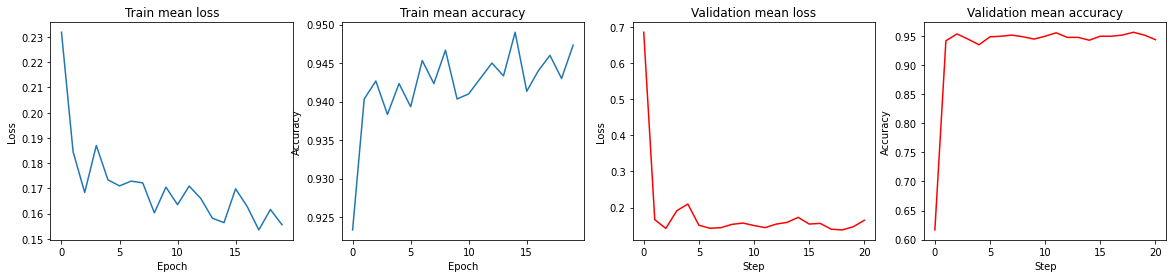

In [13]:
plot_model_metrics(model)




### Resultados nos datasets

In [14]:
trainer.test(model, train_dataloader)
trainer.test(model, val_dataloader)
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\users\pfracarolli\appdata\local\programs\python\python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:68: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'results': {'accuracy': 0.9540000000000001,
             'f1': 0.943119072660478,
             'loss': tensor(0.1347),
             'precision': 0.9855194805194807,
             'recall': 0.9042165922312981}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'results': {'accuracy': 0.9441176470588234,
             'f1': 0.9283066295274095,
             'loss': tensor(0.1647),
             'precision': 0.9905119390413508,
             'recall': 0.8734527727174787}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'results': {'accuracy': 0.9401960784313723,
             'f1': 0.927248205242795,
             'loss': tensor(0.1605),
             'precision': 0.9839759913289325,
             'recall': 0.876704775904603}}
--------------------------------------------------------------------------------


[{'results': {'loss': tensor(0.1605),
   'accuracy': 0.9401960784313723,
   'precision': 0.9839759913289325,
   'recall': 0.876704775904603,
   'f1': 0.927248205242795}}]

In [15]:
if not os.path.exists('./data/test2.hdf5'):
    !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test2.hdf5 ./data

In [16]:
test_2_dataset = MemoryHdf5Dataset('./data/test2.hdf5', transform=transform_valid)
test_2_dataloader = DataLoader(test_2_dataset, batch_size=batch_size, shuffle=False)

for x, y in test_2_dataloader:
    print(len(y[y == 1]))

0
0
0
0
0
0
11
30
30
20
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [17]:
trainer.test(model, test_2_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'results': {'accuracy': 0.9215686274509804,
             'f1': 0.029212587969725135,
             'loss': tensor(0.2370),
             'precision': 0.08088235294117647,
             'recall': 0.017825311942959002}}
--------------------------------------------------------------------------------


[{'results': {'loss': tensor(0.2370),
   'accuracy': 0.9215686274509804,
   'precision': 0.08088235294117647,
   'recall': 0.017825311942959002,
   'f1': 0.029212587969725135}}]

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.84it/s]


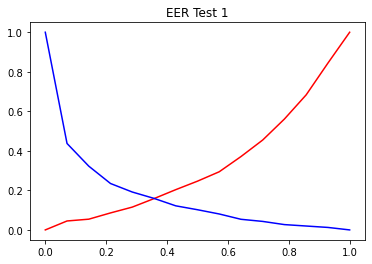

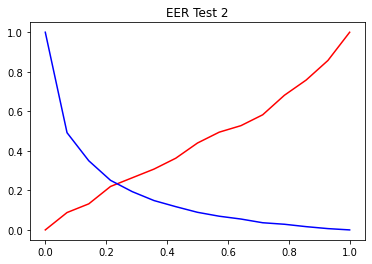

In [38]:
import tqdm

model.model.eval()

def plot_eer(dataloader, title):
    thresholds = torch.linspace(0,1,15)
    frr = []
    far = []
    
    total_acceptance = 0
    total_rejection = 0
    
    for _, y in dataloader:
        total_acceptance += len(y[y == 1])
        total_rejection += len(y[y == 0])

    for t in thresholds:
        acceptance = 0
        rejection = 0
    
        for x, y in tqdm.tqdm(dataloader):
            x = x.to('cuda')
            y = y.to('cuda')
           
            y_pred = model.model.forward(x)
            y_pred = (y_pred.sigmoid() >= t).flatten().float()
        
            acceptance += len(y_pred[(y_pred != y) & (y == 1)])
            rejection += len(y_pred[(y_pred != y) & (y == 0)])
    
        ar = acceptance / total_acceptance
        rr = rejection / total_rejection
    
        far.append(ar)
        frr.append(rr)
    
        
    fig, ax = plt.subplots(1,1)
    
    ax.set_title(title)
    ax.plot(thresholds, far, color='r')
    ax.plot(thresholds, frr, color='b')
    
plot_eer(test_dataloader, 'EER Test 1')
plot_eer(test_2_dataloader, 'EER Test 2')